In [ ]:
# Imports
from google.colab import drive
import pandas as pd
import numpy as np
import re
from pandas import read_csv
import matplotlib.pyplot as plt
from collections import Counter

In [ ]:
# When using Google colab

# Mount to drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set-up Locations

# Load GutenChrono from drive in pandas dataframe
guten_chrono = read_csv(None)
guten_chrono.info()
token_counts = read_csv(None)
token_counts.info()
fb_roberta_gc_hate = read_csv(None)
fb_roberta_gc_hate.info()
perspective_hate_stats = read_csv(None)
perspective_hate_stats.info()
shifted_words_stats = read_csv(None)
shifted_words_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25061 entries, 0 to 25060
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       25061 non-null  int64  
 1   title                    25061 non-null  object 
 2   authors                  25061 non-null  object 
 3   first_author_birth_year  25061 non-null  float64
 4   first_author_death_year  24107 non-null  float64
 5   translators              0 non-null      float64
 6   type                     25061 non-null  object 
 7   subjects                 25039 non-null  object 
 8   languages                25061 non-null  object 
 9   formats                  25061 non-null  object 
 10  downloads                25061 non-null  int64  
 11  bookshelves              4249 non-null   object 
 12  copyright                25061 non-null  bool   
 13  year_google_api          0 non-null      float64
 14  year_google_html      

In [ ]:
# Convert integer fields from object to int
guten_chrono["first_author_birth_year"] = guten_chrono[:].apply(lambda row: int(float(row["first_author_birth_year"])) if not pd.isna(row["first_author_birth_year"]) else row["first_author_birth_year"], axis=1)
guten_chrono["first_author_death_year"] = guten_chrono[:].apply(lambda row: int(float(row["first_author_death_year"])) if not pd.isna(row["first_author_death_year"]) else row["first_author_death_year"], axis=1)
guten_chrono["year_majority_vote"] = guten_chrono[:].apply(lambda row: int(float(row["year_majority_vote"])) if not pd.isna(row["year_majority_vote"]) else row["year_majority_vote"], axis=1)

token_counts['Year'] = token_counts['Year'].astype(int)
token_counts['NumTokens'] = token_counts['NumTokens'].astype(int)

fb_roberta_gc_hate['Year'] = fb_roberta_gc_hate['Year'].astype(int)
fb_roberta_gc_hate['Total Sentences'] = fb_roberta_gc_hate['Total Sentences'].astype(int)
fb_roberta_gc_hate['Hate Speech Sentences'] = fb_roberta_gc_hate['Hate Speech Sentences'].astype(int)

In [ ]:
# sanity checks
assert (guten_chrono['copyright'] == False).all()
assert (guten_chrono['year_majority_vote'] >= 1750).all()
assert (guten_chrono['year_majority_vote'] <= 2000).all()

In [ ]:
filtered_df = guten_chrono[guten_chrono['authors'].str.startswith('Twain')]
display(filtered_df)

,id,title,authors,first_author_birth_year,first_author_death_year,translators,type,subjects,languages,formats,downloads,bookshelves,copyright,year_google_api,year_google_html,year_loc,year_open_library,year_wikipedia,year_title,year_majority_vote
38,74,"The Adventures of Tom Sawyer, Complete","Twain, Mark",1835,1910.0,NaN,Text,"Adventure stories, Bildungsromans, Boys -- Fic...",en,"text/html, application/epub+zip, application/x...",9421,"Banned Books from Anne Haight's list, Banned B...",False,NaN,1876.0,NaN,1876.0,NaN,NaN,1876
39,76,Adventures of Huckleberry Finn,"Twain, Mark",1835,1910.0,NaN,Text,"Adventure stories, Bildungsromans, Boys -- Fic...",en,"text/html, application/epub+zip, application/x...",14629,Banned Books List from the American Library As...,False,NaN,1884.0,NaN,1876.0,1884.0,NaN,1876
47,86,A Connecticut Yankee in King Arthur's Court,"Twain, Mark",1835,1910.0,NaN,Text,"Americans -- Great Britain -- Fiction, Arthuri...",en,"text/html, application/epub+zip, application/x...",3460,"Precursors of Science Fiction, Arthurian Legends",False,NaN,1889.0,NaN,1889.0,1889.0,NaN,1889
49,91,Tom Sawyer Abroad,"Twain, Mark",1835,1910.0,NaN,Text,"Adventure stories, Americans -- Foreign countr...",en,"text/html, application/epub+zip, application/x...",297,NaN,False,NaN,1894.0,NaN,1910.0,1894.0,NaN,1894
51,93,"Tom Sawyer, Detective","Twain, Mark",1835,1910.0,NaN,Text,"Mystery fiction, Sawyer, Tom (Fictitious chara...",en,"text/html, application/epub+zip, application/x...",264,NaN,False,NaN,1896.0,NaN,1910.0,1896.0,NaN,1896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18141,50109,The Mysterious Stranger: A Romance,"Twain, Mark",1835,1910.0,NaN,Text,"Austria -- Fiction, Devil -- Fiction, Middle A...",en,"text/html, text/html; charset=utf-8, applicati...",91,NaN,False,NaN,NaN,NaN,1889.0,NaN,NaN,1889
21470,60900,Merry Tales,"Twain, Mark",1835,1910.0,NaN,Text,"Humorous stories, American, United States -- H...",en,"text/html, text/html; charset=utf-8, applicati...",67,NaN,False,NaN,NaN,NaN,1892.0,1892.0,NaN,1892
21641,61522,"The £1,000,000 bank-note, and other new stories","Twain, Mark",1835,1910.0,NaN,Text,"American essays -- 19th century, American fict...",en,"text/html, text/html; charset=utf-8, applicati...",346,NaN,False,NaN,NaN,NaN,1893.0,NaN,NaN,1893
21913,62636,To the Person Sitting in Darkness,"Twain, Mark",1835,1910.0,NaN,Text,"China -- History -- Boxer Rebellion, 1899-1901...",en,"text/html, text/html; charset=utf-8, applicati...",401,NaN,False,NaN,NaN,NaN,1901.0,1901.0,NaN,1901


Check for most occurring authors

In [ ]:
# Count occurrences of each unique author group
author_group_counts = guten_chrono['authors'].value_counts()


# Get the top 5 authors
top_author_groups = author_group_counts.head(5)

display(top_author_groups)


df_1750 = guten_chrono[(guten_chrono['year_majority_vote'] >= 1750) & (guten_chrono['year_majority_vote'] < 1800)]
df_1800 = guten_chrono[(guten_chrono['year_majority_vote'] >= 1800) & (guten_chrono['year_majority_vote'] < 1850)]
df_1850 = guten_chrono[(guten_chrono['year_majority_vote'] >= 1850) & (guten_chrono['year_majority_vote'] < 1900)]
df_1900 = guten_chrono[(guten_chrono['year_majority_vote'] >= 1900) & (guten_chrono['year_majority_vote'] < 1950)]
df_1950 = guten_chrono[(guten_chrono['year_majority_vote'] >= 1950) & (guten_chrono['year_majority_vote'] <= 2000)]

# Count occurrences of each author
author_counts_1750 = df_1750['authors'].value_counts().reset_index()
author_counts_1750.columns = ['authors', 'count']

author_counts_1800 = df_1800['authors'].value_counts().reset_index()
author_counts_1800.columns = ['authors', 'count']

author_counts_1850 = df_1850['authors'].value_counts().reset_index()
author_counts_1850.columns = ['authors', 'count']

author_counts_1900 = df_1900['authors'].value_counts().reset_index()
author_counts_1900.columns = ['authors', 'count']

author_counts_1950 = df_1950['authors'].value_counts().reset_index()
author_counts_1950.columns = ['authors', 'count']

# Get the top 5 authors
top_5_authors = author_counts_1750.head(5)
display(top_5_authors)

top_5_authors = author_counts_1800.head(5)
display(top_5_authors)

top_5_authors = author_counts_1850.head(5)
display(top_5_authors)

top_5_authors = author_counts_1900.head(5)
display(top_5_authors)

top_5_authors = author_counts_1950.head(5)
display(top_5_authors)

25061


,id,title,authors,first_author_birth_year,first_author_death_year,translators,type,subjects,languages,formats,...,bookshelves,copyright,year_google_api,year_google_html,year_loc,year_open_library,year_wikipedia,year_title,year_majority_vote,Authors
0,1,The Declaration of Independence of the United ...,"Jefferson, Thomas",1743,1826.0,NaN,Text,"United States -- History -- Revolution, 1775-1...",en,"text/html, application/epub+zip, application/x...",...,"American Revolutionary War, United States Law,...",False,NaN,NaN,NaN,1776.0,1776.0,NaN,1776,"Jefferson, Thomas, 1743-1826"
1,3,John F. Kennedy's Inaugural Address,"Kennedy, John F. (John Fitzgerald)",1917,1963.0,NaN,Text,Presidents -- United States -- Inaugural addre...,en,"text/html, application/epub+zip, application/x...",...,NaN,False,NaN,NaN,NaN,1962.0,1961.0,NaN,1961,"Kennedy, John F. (John Fitzgerald), 1917-1963"
2,4,Lincoln's Gettysburg Address: Given November 1...,"Lincoln, Abraham",1809,1865.0,NaN,Text,Consecration of cemeteries -- Pennsylvania -- ...,en,"text/html, application/epub+zip, application/x...",...,US Civil War,False,NaN,NaN,NaN,NaN,NaN,1863.0,1863,"Lincoln, Abraham, 1809-1865"
3,8,Abraham Lincoln's Second Inaugural Address,"Lincoln, Abraham",1809,1865.0,NaN,Text,Presidents -- United States -- Inaugural addre...,en,"text/html, text/html; charset=us-ascii, applic...",...,US Civil War,False,NaN,1865.0,NaN,NaN,1865.0,NaN,1865,"Lincoln, Abraham, 1809-1865"
4,11,Alice's Adventures in Wonderland,"Carroll, Lewis",1832,1898.0,NaN,Text,Alice (Fictitious character from Carroll) -- J...,en,"text/html, application/epub+zip, application/x...",...,Children's Literature,False,NaN,1865.0,NaN,1889.0,1865.0,NaN,1865,"Carroll, Lewis, 1832-1898"
5,12,Through the Looking-Glass,"Carroll, Lewis",1832,1898.0,NaN,Text,Alice (Fictitious character from Carroll) -- J...,en,"text/html, application/epub+zip, application/x...",...,"Children's Literature, Best Books Ever Listings",False,NaN,1871.0,NaN,1871.0,1871.0,NaN,1871,"Carroll, Lewis, 1832-1898"
6,13,The Hunting of the Snark: An Agony in Eight Fits,"Carroll, Lewis",1832,1898.0,NaN,Text,"Nonsense verses, English",en,"text/html, application/epub+zip, application/x...",...,Children's Literature,False,NaN,1876.0,NaN,1876.0,NaN,NaN,1876,"Carroll, Lewis, 1832-1898"
7,15,"Moby-Dick; or, The Whale","Melville, Herman",1819,1891.0,NaN,Text,"Adventure stories, Ahab, Captain (Fictitious c...",en,"text/html, application/epub+zip, application/x...",...,"Adventure, Best Books Ever Listings",False,NaN,1851.0,NaN,1851.0,1851.0,NaN,1851,"Melville, Herman, 1819-1891"
8,16,Peter Pan,"Barrie, J. M. (James Matthew)",1860,1937.0,NaN,Text,"Fairies -- Fiction, Fantasy literature, Never-...",en,"text/html, text/html; charset=utf-8, applicati...",...,"Children's Literature, Movie Books",False,NaN,1911.0,NaN,1911.0,1906.0,NaN,1906,"Barrie, J. M. (James Matthew), 1860-1937"
9,17,The Book of Mormon: An Account Written by the ...,"Smith, Joseph, Jr., Church of Jesus Christ of ...",1805,1844.0,NaN,Text,Church of Jesus Christ of Latter-day Saints --...,en,"text/html, application/epub+zip, application/x...",...,"Latter Day Saints, Christianity",False,NaN,NaN,NaN,1830.0,1830.0,NaN,1830,"Smith, Joseph, Jr., 1805-1844; Church of Jesus..."


,count
Cleaned_Authors,
"Twain, Mark",118
"Lytton, Edward Bulwer Lytton, Baron",104
"Ballantyne, R. M. (Robert Michael)",88
"Fenn, George Manville",87
"Henty, G. A. (George Alfred)",86


,authors,count
0,"Gibbon, Edward",14
1,"Schiller, Friedrich",7
2,"Paine, Thomas",7
3,"Wollstonecraft, Mary",7
4,"Chesterfield, Philip Dormer Stanhope, Earl of",7


,authors,count
0,"Lytton, Edward Bulwer Lytton, Baron",88
1,"Scott, Walter",44
2,"Marryat, Frederick",40
3,"Dickens, Charles",39
4,"Cooper, James Fenimore",33


,authors,count
0,"Twain, Mark",104
1,"Ballantyne, R. M. (Robert Michael)",88
2,"Henty, G. A. (George Alfred)",74
3,"Alger, Horatio, Jr.",72
4,"Fenn, George Manville",66


,authors,count
0,"Baum, L. Frank (Lyman Frank)",73
1,"Stratemeyer, Edward",59
2,"Barbour, Ralph Henry",57
3,"Oppenheim, E. Phillips (Edward Phillips)",55
4,"Wells, Carolyn",54


,authors,count
0,"Leinster, Murray",17
1,"Duellman, William Edward",11
2,"Dick, Philip K.",10
3,"Kjelgaard, Jim",10
4,"Norton, Andre",10


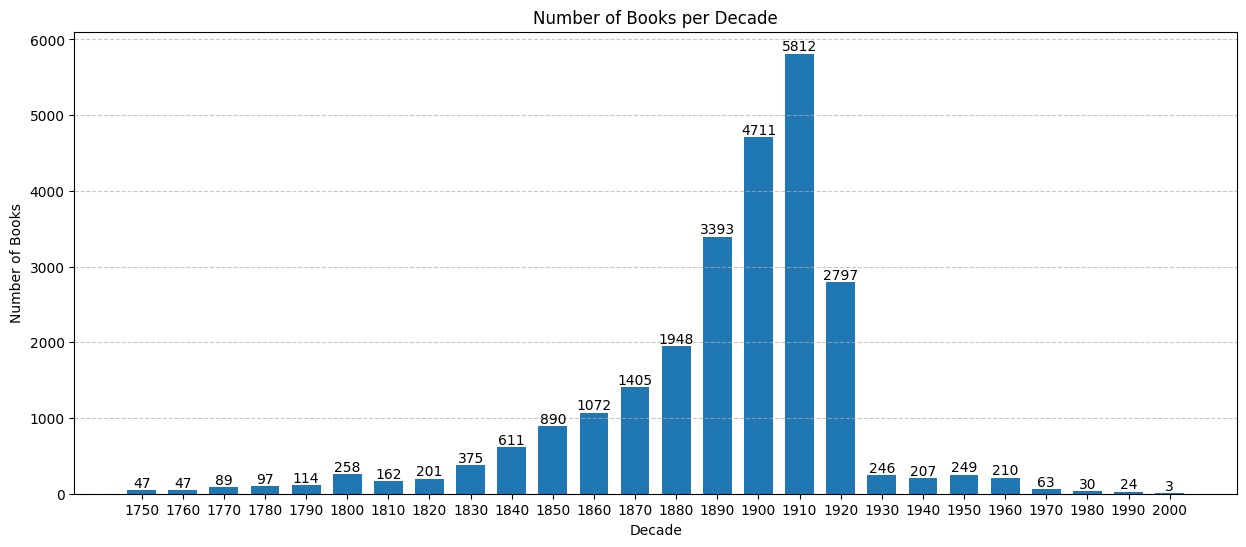

In [ ]:
# Create a dictionary to count the number of years falling into each century
century_counts = {}

# Iterate through the list of years and update the counts in the dictionary
for year in guten_chrono["year_majority_vote"]:
    century = (float(year) // 10) * 10  # Determine the century of the year
    if century in century_counts:
        century_counts[century] += 1
    else:
        century_counts[century] = 1

# Sort the dictionary by keys (centuries)
sorted_centuries = sorted(century_counts.items())

# Extract centuries and counts for plotting
centuries = [century for century, count in sorted_centuries]
counts = [count for century, count in sorted_centuries]

# Adjust the figure size
plt.figure(figsize=(15, 6))  # Increase the width and height as needed

# Plotting the bar graph
plt.bar(centuries, counts, width=7)
plt.xlabel('Decade')
plt.ylabel('Number of Books')
plt.title('Number of Books per Decade')
plt.xticks(centuries)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the count above each bar
for i, count in enumerate(counts):
    plt.text(centuries[i], count + 0.5, str(count), ha='center', va='bottom')
plt.show()

In [ ]:
print(token_counts['NumTokens'].sum())

2753590432


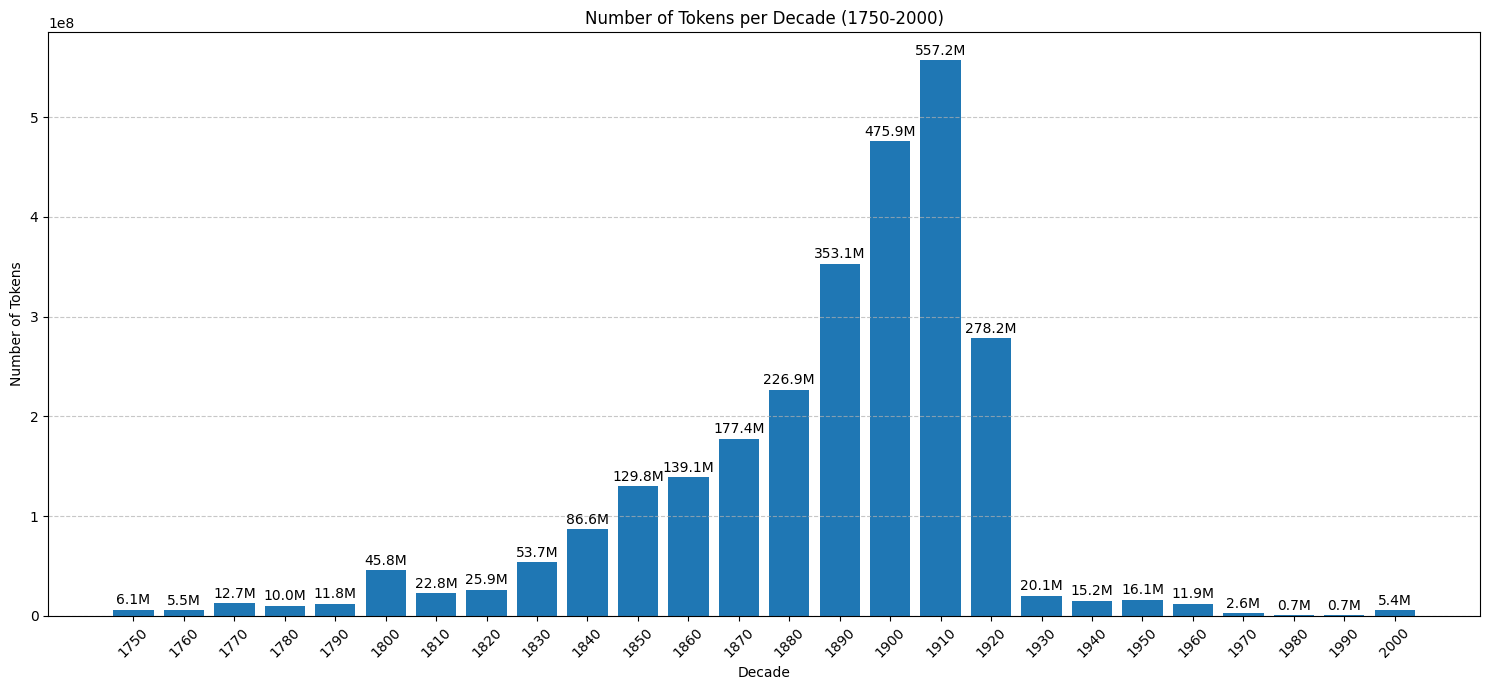

In [ ]:
# Visualize number of tokens per decade (token number was determined using transformers GPT2Tokenizer)

# Group data by decade
token_counts['Decade'] = (token_counts['Year'] // 10) * 10
tokens_per_decade = token_counts.groupby('Decade')['NumTokens'].sum().reset_index()

# Filter decades between 1750 and 2000 inclusive
tokens_per_decade = tokens_per_decade[(tokens_per_decade['Decade'] >= 1750) & (tokens_per_decade['Decade'] <= 2000)]

# Plotting
plt.figure(figsize=(15, 7))
plt.bar(tokens_per_decade['Decade'], tokens_per_decade['NumTokens'], width=8)
plt.xlabel('Decade')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens per Decade (1750-2000)')
plt.xticks(tokens_per_decade['Decade'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Function to format large numbers
def format_large_number(x):
  return f'{x / 1_000_000:.1f}M'
# Add counts above bars with formatted values
for decade, value in zip(tokens_per_decade['Decade'], tokens_per_decade['NumTokens']):
    formatted_value = format_large_number(value)
    plt.text(decade, value + 0.01 * max(tokens_per_decade['NumTokens']), formatted_value, ha='center')


plt.tight_layout()
plt.show()

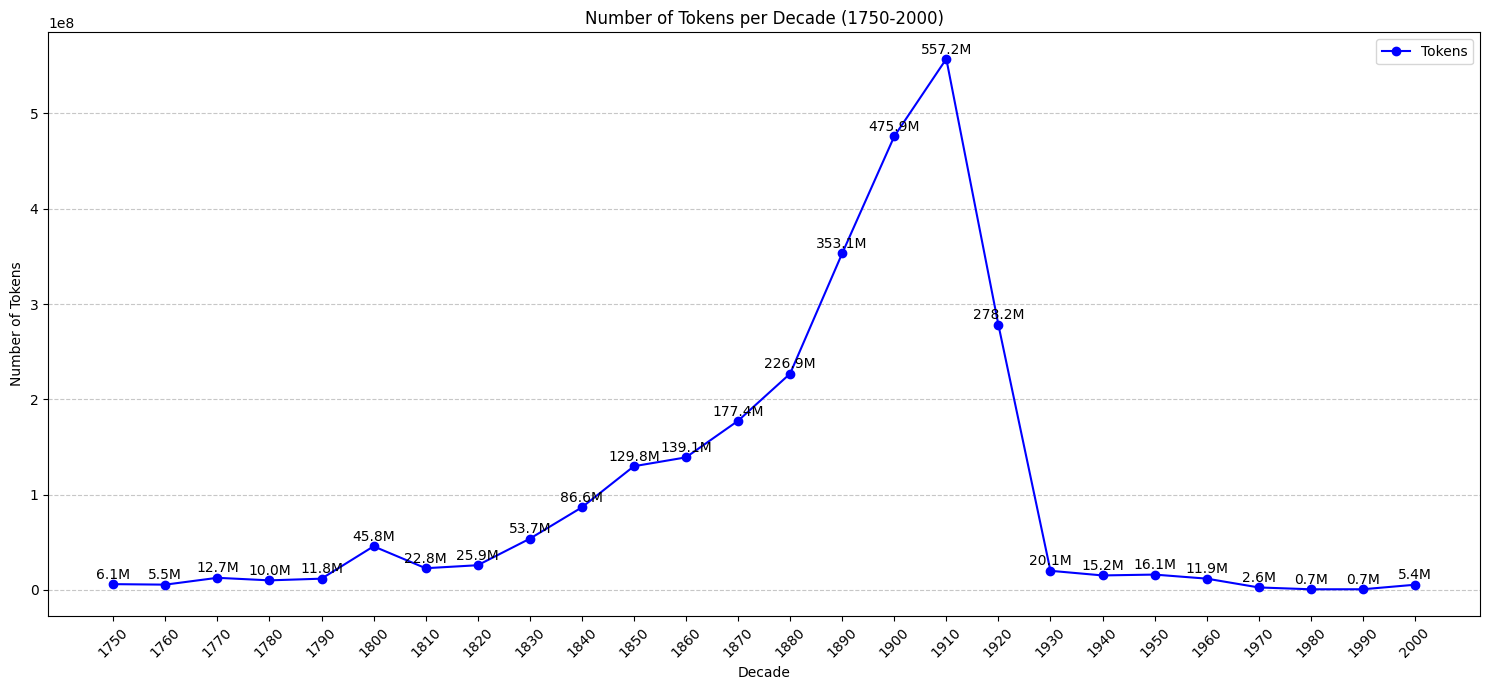

In [ ]:
import matplotlib.pyplot as plt

# Visualize number of tokens per decade (token number was determined using transformers GPT2Tokenizer)

# Group data by decade
token_counts['Decade'] = (token_counts['Year'] // 10) * 10
tokens_per_decade = token_counts.groupby('Decade')['NumTokens'].sum().reset_index()

# Filter decades between 1750 and 2000 inclusive
tokens_per_decade = tokens_per_decade[(tokens_per_decade['Decade'] >= 1750) & (tokens_per_decade['Decade'] <= 2000)]

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(tokens_per_decade['Decade'], tokens_per_decade['NumTokens'], marker='o', linestyle='-', color='b', label='Tokens')

# Adding labels and title
plt.xlabel('Decade')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens per Decade (1750-2000)')
plt.xticks(tokens_per_decade['Decade'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Function to format large numbers
def format_large_number(x):
    return f'{x / 1_000_000:.1f}M'

# Annotate points with formatted values
for decade, value in zip(tokens_per_decade['Decade'], tokens_per_decade['NumTokens']):
    formatted_value = format_large_number(value)
    plt.text(decade, value + 0.01 * max(tokens_per_decade['NumTokens']), formatted_value, ha='center', fontsize=10)

# Add legend
plt.legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


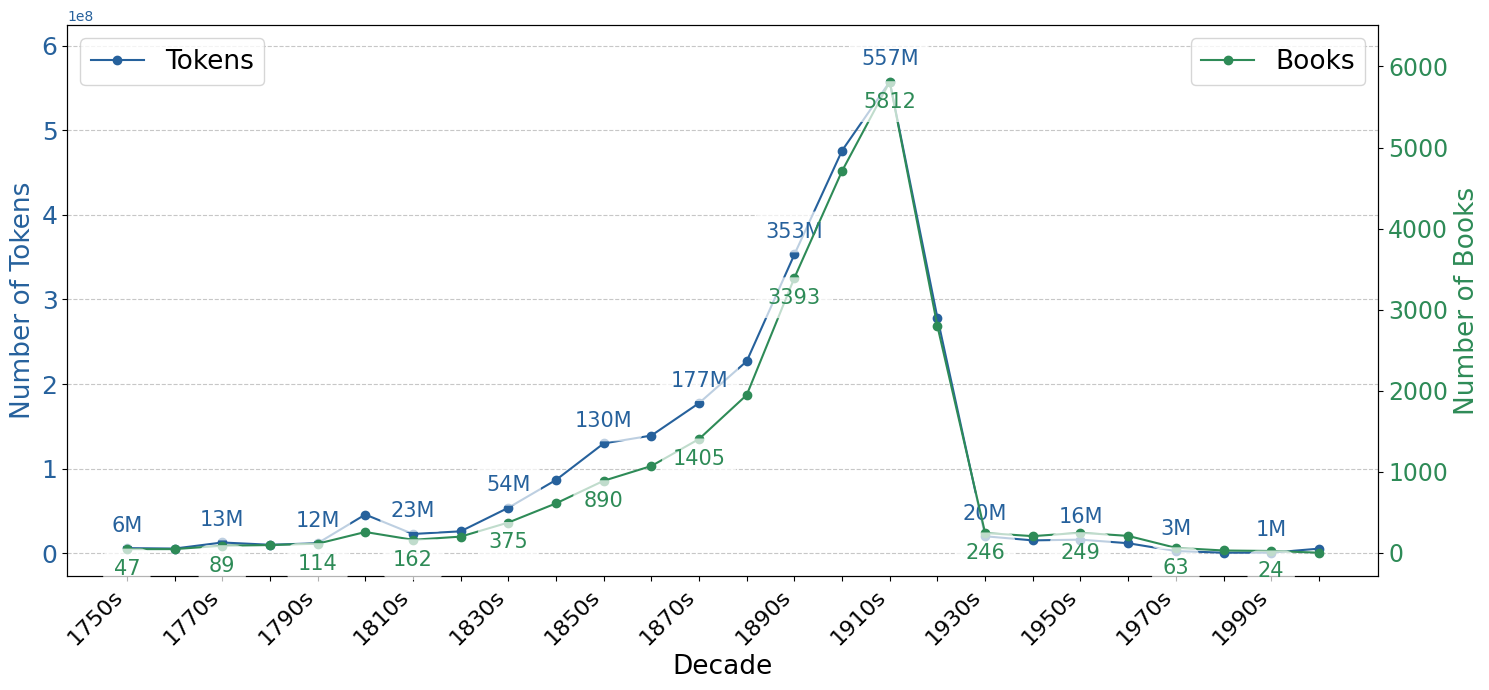

In [ ]:
import matplotlib.pyplot as plt

# Tokens per decade
token_counts['Decade'] = (token_counts['Year'] // 10) * 10
tokens_per_decade = token_counts.groupby('Decade')['NumTokens'].sum().reset_index()

tokens_per_decade = tokens_per_decade[(tokens_per_decade['Decade'] >= 1750) & (tokens_per_decade['Decade'] <= 2000)]

# Books per decade
century_counts = {}
for year in guten_chrono["year_majority_vote"]:
    decade = (float(year) // 10) * 10
    if decade in century_counts:
        century_counts[decade] += 1
    else:
        century_counts[decade] = 1

sorted_centuries = sorted(century_counts.items())
book_decades = [century for century, count in sorted_centuries]
book_counts = [count for century, count in sorted_centuries]

filtered_books = [(decade, count) for decade, count in zip(book_decades, book_counts) if 1750 <= decade <= 2000]
book_decades, book_counts = zip(*filtered_books)

# Plotting
fig, ax1 = plt.subplots(figsize=(15, 7))

font_size = 19

# Tokens line
ax1.plot(tokens_per_decade['Decade'], tokens_per_decade['NumTokens'], marker='o', linestyle='-', color='#26619c', label='Tokens')
ax1.set_xlabel('Decade', fontsize=font_size)
ax1.set_ylabel('Number of Tokens', color='#26619c', fontsize=font_size)
ax1.tick_params(axis='y', labelcolor='#26619c', labelsize=font_size-1)

# Create labels
decade_labels = [f"{year}s" if i % 2 == 0 else "" for i, year in enumerate(tokens_per_decade['Decade'])]
ax1.set_xticks(tokens_per_decade['Decade'])  # Set all decades as x-ticks
ax1.set_xticklabels(decade_labels, rotation=45, ha='right', fontsize=font_size - 3)  # Label every second tick

ax1.grid(axis='y', linestyle='--', alpha=0.7)

def format_large_number(x):
    return f'{x / 1_000_000:.0f}M'

for i, (decade, value) in enumerate(zip(tokens_per_decade['Decade'], tokens_per_decade['NumTokens'])):
    if i % 2 == 0:
        formatted_value = format_large_number(value)
        # Determine the position of token annotation relative to book value
        book_value = book_counts[book_decades.index(decade)]
        y_offset = 0.035 * max(tokens_per_decade['NumTokens'])
        ax1.text(
            decade,
            value + y_offset,
            formatted_value,
            ha='center',
            fontsize=font_size-4,
            color='#26619c',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
        )

# Books line
ax2 = ax1.twinx()
ax2.plot(book_decades, book_counts, marker='o', linestyle='-', color='#2e8b57', label='Books')
ax2.set_ylabel('Number of Books', color='#2e8b57', fontsize=font_size)
ax2.tick_params(axis='y', labelcolor='#2e8b57', labelsize=font_size-2)

# Annotate books above or below based on comparison with tokens
for i, (decade, count) in enumerate(zip(book_decades, book_counts)):
    if i % 2 == 0:

        token_value = tokens_per_decade[tokens_per_decade['Decade'] == (decade)]['NumTokens'].values[0]
        y_offset = -0.055 * max(book_counts)
        ax2.text(
            decade,
            count + y_offset,
            str(count),
            ha='center',
            fontsize=font_size-4,
            color='#2e8b57',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.5')
        )

# Add title and legends

ax1.legend(loc='upper left', fontsize=font_size)
ax2.legend(loc='upper right', fontsize=font_size)

ax1.set_ylim(None, max(tokens_per_decade['NumTokens']) * 1.12)
ax2.set_ylim(None, max(book_counts) * 1.12)

plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
from collections import Counter

print(len(guten_chrono.loc[guten_chrono['subjects'].isnull()]))
print(len(guten_chrono.loc[guten_chrono['bookshelves'].isnull()]))

total_books = len(guten_chrono)

print(f"Items with subject entry {guten_chrono['subjects'].notna().sum()}")


subjects_list = guten_chrono['subjects'].str.split(' -- ').explode()

subject_counts = Counter(subjects_list)


#Get the 10 most common subjects
subject_counts = subject_counts.most_common(10)

#Calculate the percentage for each subject
subject_info = []
for subject, count in subject_counts:
    percentage = (count / total_books) * 100
    subject_info.append((subject, count, percentage))

print("Top 10 most common subjects with their counts and percentage of books tagged with them:")
for subject, count, percentage in subject_info:
    print(f"{subject} & {count} & {percentage:.1f}\% \\\\")


22
20812
Items with subject entry 25039
Top 10 most common subjects with their counts and percentage of books tagged with them:
Fiction & 5998 & 23.9\% \\
History & 3012 & 12.0\% \\
Juvenile fiction & 2368 & 9.4\% \\
Social life and customs & 1450 & 5.8\% \\
19th century & 1218 & 4.9\% \\
England & 1154 & 4.6\% \\
United States & 1052 & 4.2\% \\
Great Britain & 872 & 3.5\% \\
Description and travel & 830 & 3.3\% \\
Conduct of life & 695 & 2.8\% \\


In [ ]:
print(f"Items with bookshelves entry: {guten_chrono['bookshelves'].notna().sum()}")

comma_sep_categories = ["Bestsellers, American, 1895-1923",
                        "Birds, Illustrated by Color Photography",
                        "Children's Myths, Fairy Tales, etc.",
                        "FR Biographie, Mémoires, Journal intime, Correspondance",
                        "FR La Première Guerre Mondiale, 1914-1918",
                        "FR Livres, Collections et Bibliophilie",
                        "FR Philosophie, Religion et Morale",
                        "Pirates, Buccaneers, Corsairs, etc.",
                        "Poetry, A Magazine of Verse",
                        "The International Magazine of Literature, Art, and Science",
                        "The Mirror of Literature, Amusement, and Instruction",
                        "The Mirror of Taste, and Dramatic Censor"]

bookshelves_df = guten_chrono.loc[guten_chrono['bookshelves'].notnull()]
total_books = len(bookshelves_df)

# replace commas in categories inlcuding commas with semicolons
bookshelves_df = guten_chrono.loc[guten_chrono['bookshelves'].notnull()].copy()
for category in comma_sep_categories:
    placeholder = category.replace(',', ';')
    bookshelves_df['bookshelves'] = bookshelves_df['bookshelves'].str.replace(category, placeholder)

bookshelves_list = bookshelves_df['bookshelves'].str.split(', ').explode()

# Restore commas in specific categories
bookshelves_list = bookshelves_list.str.replace(';', ',')

# Count the frequency of each bookshelf
bookshelf_counts = Counter(bookshelves_list)

# Get the 10 most common bookshelves
bookshelf_counts = bookshelf_counts.most_common(10)

# Calculate percentage
total_books = len(bookshelves_df)
bookshelf_info = []
for bookshelf, count in bookshelf_counts:
    percentage = (count / total_books) * 100
    bookshelf_info.append((bookshelf, count, percentage))

print("Top 10 most common bookshelves with their counts and percentage of books tagged with them:")
for bookshelf, count, percentage in bookshelf_info:
    print(f"{bookshelf} & {count} & {percentage:.1f}\\% \\\\")


Items with bookshelves entry: 4249
Top 10 most common bookshelves with their counts and percentage of books tagged with them:
Bestsellers, American, 1895-1923 & 308 & 7.2\% \\
Science Fiction & 285 & 6.7\% \\
Children's Fiction & 282 & 6.6\% \\
Children's Book Series & 207 & 4.9\% \\
Children's Literature & 203 & 4.8\% \\
World War I & 196 & 4.6\% \\
US Civil War & 192 & 4.5\% \\
Historical Fiction & 186 & 4.4\% \\
Humor & 100 & 2.4\% \\
Native America & 98 & 2.3\% \\


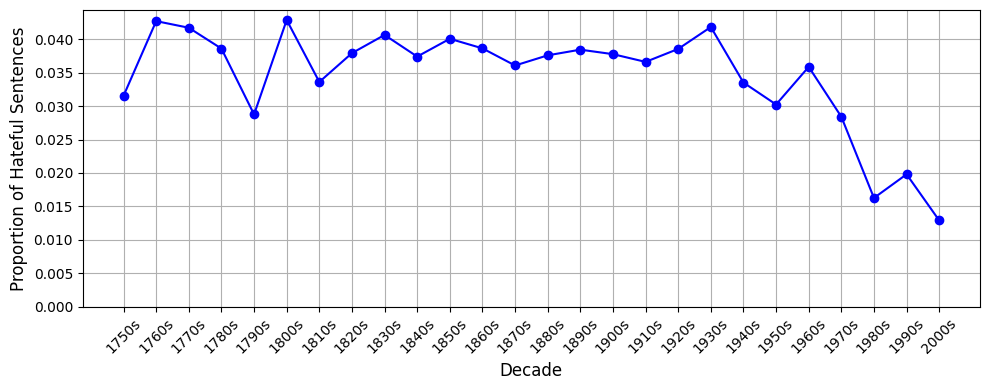

In [ ]:
# Sentences flagged by FB Roberta in proportion to all sentences per decade

import pandas as pd
import matplotlib.pyplot as plt

# decade
fb_roberta_gc_hate['Decade'] = (fb_roberta_gc_hate['Year'] // 10) * 10

# Aggregate by decade
decade_data = fb_roberta_gc_hate.groupby('Decade', as_index=False).sum()

#Calculate proportion of hate speech sents
decade_data['Proportion Hateful'] = (
    decade_data['Hate Speech Sentences'] / decade_data['Total Sentences']
)

plt.figure(figsize=(10, 4))
plt.plot(
    decade_data['Decade'],
    decade_data['Proportion Hateful'],
    marker='o',
    linestyle='-',
    color='b'
)

plt.xlabel('Decade', fontsize=12)
plt.ylabel('Proportion of Hateful Sentences', fontsize=12)
plt.grid(True)

decade_labels = [f"{int(year)}s" for year in decade_data['Decade']]
plt.xticks(decade_data['Decade'], labels=decade_labels, rotation=45)

plt.ylim(0, None)  # Set y-axis to start at 0
plt.tight_layout()
plt.show()


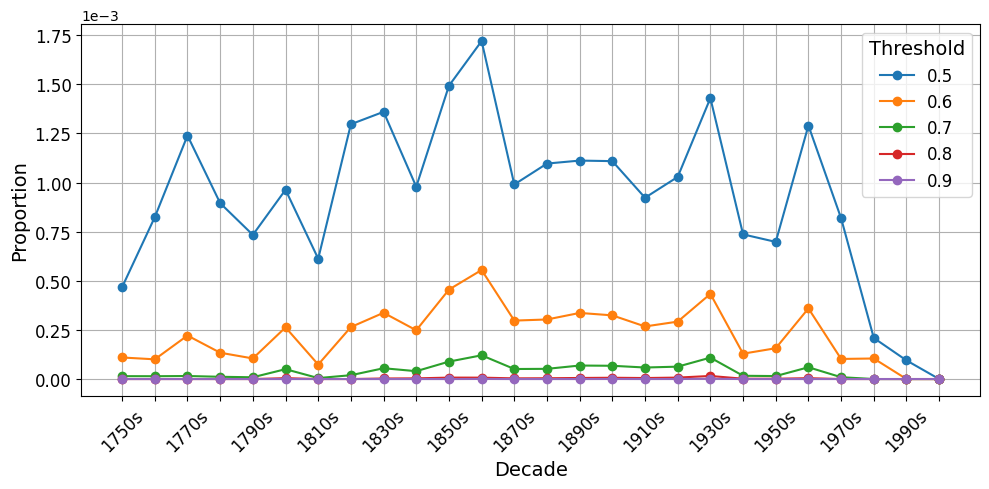

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# all relevant GP API thresholds

merged_df = pd.merge(perspective_hate_stats, fb_roberta_gc_hate, on='Year', how='inner')

merged_df["Decade"] = (merged_df["Year"] // 10) * 10

# by decade
agg_df = merged_df.groupby("Decade")[["Total Sentences"] + [col for col in merged_df.columns if col.startswith("Threshold")]].sum().reset_index()

# relative threshold values
threshold_columns = ["Threshold 0.5", "Threshold 0.6", "Threshold 0.7", "Threshold 0.8", "Threshold 0.9"]
for threshold in threshold_columns:
    agg_df[threshold] = agg_df[threshold] / agg_df["Total Sentences"]

# Set font size varialbe
font_size = 14

plt.figure(figsize=(10, 5))

for threshold in threshold_columns:
    plt.plot(
        agg_df["Decade"],
        agg_df[threshold],
        marker="o",
        label=threshold.split(" ")[1]
    )

# Update the x-axis to show decades as "1850s"
decade_labels = [f"{year}s" if i % 2 == 0 else "" for i, year in enumerate(agg_df["Decade"])]
plt.xticks(agg_df["Decade"], labels=decade_labels, fontsize=font_size-2, rotation=45)

plt.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
plt.gca().yaxis.get_offset_text()
plt.yticks(fontsize=font_size-2)

# Configure axis labels and legend
plt.xlabel("Decade", fontsize=font_size)
plt.ylabel("Proportion", fontsize=font_size)
plt.legend(title="Threshold", fontsize=font_size - 2, title_fontsize=font_size)
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
print(fb_roberta_gc_hate["Total Sentences"].sum()) 88.757.284

88757284


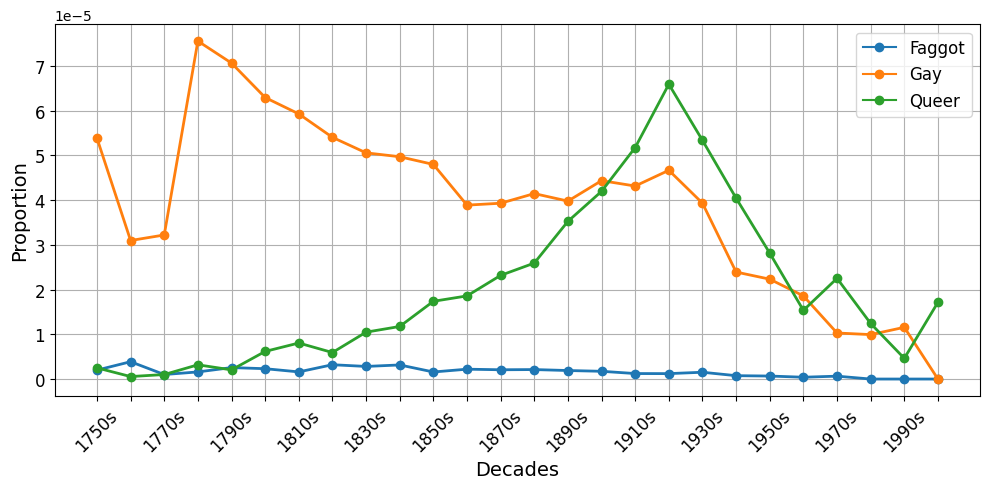

In [ ]:
shifted_words_stats['decade'] = (shifted_words_stats['Year'] // 10) * 10

# Group by decade and sum counts
grouped = shifted_words_stats.groupby('decade').sum()

# Calculate proportions
grouped['fag_proportion'] = grouped['fag_count'] / grouped['word_count']
grouped['gay_proportion'] = grouped['gay_count'] / grouped['word_count']
grouped['queer_proportion'] = grouped['queer_count'] / grouped['word_count']

#Proportions over decades
plt.figure(figsize=(10, 5))

plt.plot(grouped.index, grouped['fag_proportion'], label='Faggot', marker='o')
plt.plot(grouped.index, grouped['gay_proportion'], label='Gay', marker='o')
plt.plot(grouped.index, grouped['queer_proportion'], label='Queer', marker='o')

# font sizes for all elements
font_size = 14
plt.xlabel('Decades', fontsize=font_size)
plt.ylabel('Proportion', fontsize=font_size)
plt.xticks(grouped.index,
           [f"{int(decade)}s" if i % 2 == 0 else "" for i, decade in enumerate(grouped.index)],
           fontsize=font_size - 2, rotation=45)
plt.yticks(fontsize=font_size - 2)
plt.legend(fontsize=font_size - 2)
plt.grid(True)

# Increase line width
plt.gca().lines[0].set_linewidth(2)
plt.gca().lines[1].set_linewidth(2)
plt.gca().lines[2].set_linewidth(2)

plt.tight_layout()

plt.show()
